##Name : Kushal Ghimire            
##Student Id: C0903150

###PySpark Assignment in Databricks: Analyzing and Modeling Flight Delays Data

##**Step 1: Data Loading and Initial Exploration** 

In [0]:
# Import Spark Session
from pyspark.sql import SparkSession

In [0]:
# Importing Necessary libraries
from pyspark.sql.functions import col, when, concat, lit, to_date, dayofweek, count,month,year
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as F
from pyspark.ml.feature import Imputer
# Plot using Matplotlib
import matplotlib.pyplot as plt

In [0]:
# Initialize Spark session
spark = SparkSession.builder.appName("FlightDelays&Cancellation").getOrCreate()

**1. Load Data**

In [0]:
# Load the dataset from the uploaded location
file_path = "dbfs:/FileStore/2016.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

**2. Initial Exploration**

In [0]:
# Display schema
df.printSchema()

root
 |-- FLIGHT_DATE : string (nullable = true)
 |-- AirlineIdentifier: string (nullable = true)
 |-- FlightNumber: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- PlannedDepTime: integer (nullable = true)
 |-- ActualDepTime: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- WheelsOff: integer (nullable = true)
 |-- WheelsOn: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- PlannedArrivalTime: integer (nullable = true)
 |-- ArrivalTime: integer (nullable = true)
 |-- ArrivalDelay: integer (nullable = true)
 |-- AirTime: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)
 |-- CANCELLATION_REASON: string (nullable = true)
 |-- AIR_SYSTEM_DELAY: integer (nullable = true)
 |-- SECURITY_DELAY: integer (nullable = true)
 |-- AIRLINE_DELAY: integer (nullable = true)
 |-- LATE_AIRCRAFT_DELAY: integ

In [0]:
# Display the first 10 rows of the DataFrame
display(df.limit(10))

FLIGHT_DATE,AirlineIdentifier,FlightNumber,Origin,Dest,PlannedDepTime,ActualDepTime,DepDelay,TaxiOut,WheelsOff,WheelsOn,TaxiIn,PlannedArrivalTime,ArrivalTime,ArrivalDelay,AirTime,Distance,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY
2015-04-21 (2),DL,1248,DTW,LAX,1935,1935,0,23,1958,2107,13,2144,2120,-24,249,1979,0,null,null,null,null,null
2015-04-07 (2),DL,1251,ATL,GRR,2125,2130,5,13,2143,2315,4,2321,2319,-2,92,640,0,null,null,null,null,null
2015-07-24 (5),DL,1254,LAX,ATL,2255,2256,1,19,2315,542,5,600,547,-13,207,1947,0,null,null,null,null,null
2015-02-13 (5),DL,1255,SLC,ATL,1656,1700,4,12,1712,2205,8,2229,2213,-16,173,1590,0,null,null,null,null,null
2015-09-05 (6),DL,1256,BZN,MSP,900,1012,72,63,1115,1416,4,1216,1420,124,121,874,0,null,null,null,null,null
2015-03-07 (6),DL,1257,ATL,BNA,1233,1356,83,22,1418,1356,6,1239,1402,83,38,214,0,null,0,0,0,42
2015-06-04 (4),DL,1257,BNA,ATL,1320,1446,86,15,1501,1638,6,1530,1644,74,37,214,0,null,null,null,null,null
2015-06-11 (4),DL,1258,ATL,JAX,945,946,1,19,1005,1050,3,1050,1053,3,45,270,0,null,null,null,null,null
2015-02-28 (6),DL,1258,JAX,ATL,1145,1144,-1,12,1156,1239,8,1302,1247,-15,43,270,0,null,0,0,2,21
2015-02-21 (6),DL,1259,ATL,OKC,2110,2107,-3,16,2123,2219,5,2236,2224,-12,116,761,0,null,0,0,28,0


**Count the number of rows and columns.**

In [0]:
# Count the number of rows and columns.
num_rows = df.count()
num_columns = len(df.columns)
print(f"Number of rows: {num_rows}, Number of columns: {num_columns}")


Number of rows: 872860, Number of columns: 23


**Questions:**

**How many rows and columns does the dataset contain**?
- Answer : There are 872860 rows and 23 columns.

**What are the data types of each column?**

 Answer: The data types of each column are displayed using printSchema().
 Here are the data types of each column in text form:
**FLIGHT_DATE**: string,
**AirlineIdentifier**: string,
**FlightNumber**: integer,
**Origin**: string,
**Dest**: string,
**PlannedDepTime**: integer,
**ActualDepTime**: integer,
**DepDelay**: integer,
**TaxiOut**: integer,
**WheelsOff**: integer,
**WheelsOn**: integer,
**TaxiIn**: integer,
**PlannedArrivalTime**: integer,
**ArrivalTime**: integer,
**ArrivalDelay**: integer,
**AirTime**: integer,
**Distance**: integer,
**CANCELLED** : integer,
**CANCELLATION_REASON** : string,
**AIR_SYSTEM_DELAY** : integer,
**SECURITY_DELAY**: integer,
**AIRLINE_DELAY** : integer,
**LATE_AIRCRAFT_DELAY** : integer








##**Step 2: Data Cleaning and Transformation**

**1. Handle Missing Values**

In [0]:
# Count the number of missing values in each column
missing_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
display(missing_counts)

FLIGHT_DATE,AirlineIdentifier,FlightNumber,Origin,Dest,PlannedDepTime,ActualDepTime,DepDelay,TaxiOut,WheelsOff,WheelsOn,TaxiIn,PlannedArrivalTime,ArrivalTime,ArrivalDelay,AirTime,Distance,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY
0,0,0,0,0,0,18136,18136,18458,18458,19061,19061,0,19061,20420,20420,0,0,859366,713703,713703,713703,713703


In [0]:
# Impute missing values for numerical columns with mean or median
from pyspark.ml.feature import Imputer

numerical_columns = ['ActualDepTime', 'DepDelay', 'TaxiOut', 'WheelsOff', 
                     'WheelsOn', 'TaxiIn', 'ArrivalTime','ArrivalDelay', 'AirTime','AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY']

imputer = Imputer(inputCols=numerical_columns, outputCols=[f"{col}_imputed" for col in numerical_columns]).setStrategy("median")
df = imputer.fit(df).transform(df)

In [0]:
# Impute categorical columns with "Unknown" for missing values
categorical_columns = ['CANCELLATION_REASON']

for column in categorical_columns:
    df = df.na.fill({column: 'Unknown'})


**2. Feature Engineering: Create new features that may be useful for analysis.**

In [0]:
# Remove anything after the actual date, e.g., "(2)"
df = df.withColumn("FLIGHT_DATE ", regexp_replace(col("FLIGHT_DATE "), r"(\s*\(.*\))", ""))


In [0]:
# Convert FLIGHT_DATE  to a proper date type
df = df.withColumn("FLIGHT_DATE ", to_date(col("FLIGHT_DATE "), "yyyy-MM-dd"))

In [0]:
# Feature Engineering
# Extract day of week, month, and year from FLIGHT_DATE 
df = df.withColumn("DAY_OF_WEEK", dayofweek(col("FLIGHT_DATE "))) \
                       .withColumn("MONTH", month(col("FLIGHT_DATE "))) \
                       .withColumn("YEAR", year(col("FLIGHT_DATE ")))



In [0]:
# Create a binary column indicating if a flight was delayed

df = df.withColumn("WasDelayed", when(col("ArrivalDelay") > 0, 1).otherwise(0))
df = df.withColumn("WasDepartureDelayed", when(col("DepDelay") > 0, 1).otherwise(0))
df = df.withColumn("WasArrivalLate", when(col("ArrivalDelay") > 0, 1).otherwise(0))
df = df.withColumn("AirSystemDelayOccurred", when(col("AIR_SYSTEM_DELAY") > 0, 1).otherwise(0))
df = df.withColumn("SecurityDelayOccurred", when(col("SECURITY_DELAY") > 0, 1).otherwise(0))
df = df.withColumn("AirlineDelayOccurred", when(col("AIRLINE_DELAY") > 0, 1).otherwise(0))
df = df.withColumn("LateAircraftDelayOccurred", when(col("LATE_AIRCRAFT_DELAY") > 0, 1).otherwise(0))


In [0]:
# Show updated schema and a sample of the transformed data
df.printSchema()
display(df.limit(10))

root
 |-- FLIGHT_DATE : date (nullable = true)
 |-- AirlineIdentifier: string (nullable = true)
 |-- FlightNumber: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- PlannedDepTime: integer (nullable = true)
 |-- ActualDepTime: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- WheelsOff: integer (nullable = true)
 |-- WheelsOn: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- PlannedArrivalTime: integer (nullable = true)
 |-- ArrivalTime: integer (nullable = true)
 |-- ArrivalDelay: integer (nullable = true)
 |-- AirTime: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)
 |-- CANCELLATION_REASON: string (nullable = false)
 |-- AIR_SYSTEM_DELAY: integer (nullable = true)
 |-- SECURITY_DELAY: integer (nullable = true)
 |-- AIRLINE_DELAY: integer (nullable = true)
 |-- LATE_AIRCRAFT_DELAY: intege

FLIGHT_DATE,AirlineIdentifier,FlightNumber,Origin,Dest,PlannedDepTime,ActualDepTime,DepDelay,TaxiOut,WheelsOff,WheelsOn,TaxiIn,PlannedArrivalTime,ArrivalTime,ArrivalDelay,AirTime,Distance,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,ActualDepTime_imputed,DepDelay_imputed,TaxiOut_imputed,WheelsOff_imputed,WheelsOn_imputed,TaxiIn_imputed,ArrivalTime_imputed,ArrivalDelay_imputed,AirTime_imputed,AIR_SYSTEM_DELAY_imputed,SECURITY_DELAY_imputed,AIRLINE_DELAY_imputed,LATE_AIRCRAFT_DELAY_imputed,DAY_OF_WEEK,MONTH,YEAR,WasDelayed,WasDepartureDelayed,WasArrivalLate,AirSystemDelayOccurred,SecurityDelayOccurred,AirlineDelayOccurred,LateAircraftDelayOccurred
2015-04-21,DL,1248,DTW,LAX,1935,1935,0,23,1958,2107,13,2144,2120,-24,249,1979,0,Unknown,null,null,null,null,1935,0,23,1958,2107,13,2120,-24,249,2,0,2,3,3,4,2015,0,0,0,0,0,0,0
2015-04-07,DL,1251,ATL,GRR,2125,2130,5,13,2143,2315,4,2321,2319,-2,92,640,0,Unknown,null,null,null,null,2130,5,13,2143,2315,4,2319,-2,92,2,0,2,3,3,4,2015,0,1,0,0,0,0,0
2015-07-24,DL,1254,LAX,ATL,2255,2256,1,19,2315,542,5,600,547,-13,207,1947,0,Unknown,null,null,null,null,2256,1,19,2315,542,5,547,-13,207,2,0,2,3,6,7,2015,0,1,0,0,0,0,0
2015-02-13,DL,1255,SLC,ATL,1656,1700,4,12,1712,2205,8,2229,2213,-16,173,1590,0,Unknown,null,null,null,null,1700,4,12,1712,2205,8,2213,-16,173,2,0,2,3,6,2,2015,0,1,0,0,0,0,0
2015-09-05,DL,1256,BZN,MSP,900,1012,72,63,1115,1416,4,1216,1420,124,121,874,0,Unknown,null,null,null,null,1012,72,63,1115,1416,4,1420,124,121,2,0,2,3,7,9,2015,1,1,1,0,0,0,0
2015-03-07,DL,1257,ATL,BNA,1233,1356,83,22,1418,1356,6,1239,1402,83,38,214,0,Unknown,0,0,0,42,1356,83,22,1418,1356,6,1402,83,38,0,0,0,42,7,3,2015,1,1,1,0,0,0,1
2015-06-04,DL,1257,BNA,ATL,1320,1446,86,15,1501,1638,6,1530,1644,74,37,214,0,Unknown,null,null,null,null,1446,86,15,1501,1638,6,1644,74,37,2,0,2,3,5,6,2015,1,1,1,0,0,0,0
2015-06-11,DL,1258,ATL,JAX,945,946,1,19,1005,1050,3,1050,1053,3,45,270,0,Unknown,null,null,null,null,946,1,19,1005,1050,3,1053,3,45,2,0,2,3,5,6,2015,1,1,1,0,0,0,0
2015-02-28,DL,1258,JAX,ATL,1145,1144,-1,12,1156,1239,8,1302,1247,-15,43,270,0,Unknown,0,0,2,21,1144,-1,12,1156,1239,8,1247,-15,43,0,0,2,21,7,2,2015,0,0,0,0,0,1,1
2015-02-21,DL,1259,ATL,OKC,2110,2107,-3,16,2123,2219,5,2236,2224,-12,116,761,0,Unknown,0,0,28,0,2107,-3,16,2123,2219,5,2224,-12,116,0,0,28,0,7,2,2015,0,0,0,0,0,1,0


**Which columns had missing values, and how did you handle them?**               
Answer: ActualDepTime,DepDelay,TaxiOut,WheelsOff,WheelsOn,TaxiIn,ArrivalTime,ArrivalDelay,AirTime,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY and LATE_AIRCRAFT_DELAY columns have missing values.
**Imputation technique** is used to handle missing values for numerical columns.
The median value was used for imputation to ensure that the imputation is robust against outliers.
**Median imputation** is used because it is less sensitive to extreme outliers compared to mean imputation, ensuring that the imputed values are more representative of typical values in the dataset.
For Categorical columns , we impute using **Unknown** values.


**What new features did you create, and why?**

The new features created include DAY_OF_WEEK, MONTH,YEAR and WasDelayed. The DAY_OF_WEEK, MONTH and YEAR features were extracted from the FLIGHT_DATE column to capture temporal patterns such as weekly or seasonal variations that could influence flight delays. WasDelayed is a binary feature derived from ArrivalDelay to indicate whether a flight was delayed (value of 1 if delay > 0, else 0). These features help in better understanding the impact of time-related factors on delays and simplify predictive modeling by creating clear, categorical indicators that can improve model performance.

##**Step 3: Exploratory Data Analysis (EDA) using Spark SQL**

**1. Register DataFrame as a Temporary Table: Register the DataFrame as a temporary table to use 
SQL queries.**

In [0]:
# Register the DataFrame as a temporary table
df.createOrReplaceTempView("flights")

**2. SQL Queries: Perform the following analyses using Spark SQL:**

**Calculate the average delay time for each airline.**

In [0]:
# Average Delay time for Each Airline
average_delay_airline = spark.sql("""
    SELECT AirlineIdentifier, AVG(ArrivalDelay) AS AverageArrivalDelay
    FROM flights
    GROUP BY AirlineIdentifier
    ORDER BY AverageArrivalDelay DESC
""")

# Show the results
average_delay_airline.show()


+-----------------+-------------------+
|AirlineIdentifier|AverageArrivalDelay|
+-----------------+-------------------+
|               NK| 16.120191609812746|
|               B6|  13.26877415472912|
|               OO|  5.413006143074179|
|               VX| 4.3464681844716875|
|               EV| 2.8303697216616532|
|               AA| 1.4225160099555356|
|               DL| -1.210882902499669|
|               HA|-1.4672557601783798|
|               WN| -1.569883802464189|
|               UA| -3.216790744727763|
|               F9| -3.669669226225635|
|               AS| -4.854136110296275|
+-----------------+-------------------+



**Identify the top 5 airports with the most delayed departures.**

In [0]:
# Top 5 airports with the most delayed departures.
top_delayed_airports = spark.sql("""
    SELECT Origin, COUNT(*) AS TotalDelays
    FROM flights
    WHERE DepDelay > 0
    GROUP BY Origin
    ORDER BY TotalDelays DESC
    LIMIT 5
""")

# Show the results
top_delayed_airports.show()


+------+-----------+
|Origin|TotalDelays|
+------+-----------+
|   ATL|      20495|
|   ORD|      14780|
|   LAX|      11815|
|   DEN|      10868|
|   DFW|       9550|
+------+-----------+



**Determine the most common reason for flight cancellations.**

In [0]:
# Determine the most common reason for flight cancellations using the CANCELLATION_REASON column
most_common_cancellation_reason = spark.sql("""
    SELECT CANCELLATION_REASON, COUNT(*) AS Count
    FROM flights
    WHERE CANCELLED = 1
    GROUP BY CANCELLATION_REASON
    ORDER BY Count DESC
    LIMIT 1
""")
most_common_cancellation_reason.show()


+-------------------+-----+
|CANCELLATION_REASON|Count|
+-------------------+-----+
|                  B| 7344|
+-------------------+-----+



**3. Visualization: Use Databricks visualizations or matplotlib to visualize key findings.**

**Plot the average delay by airline.** 

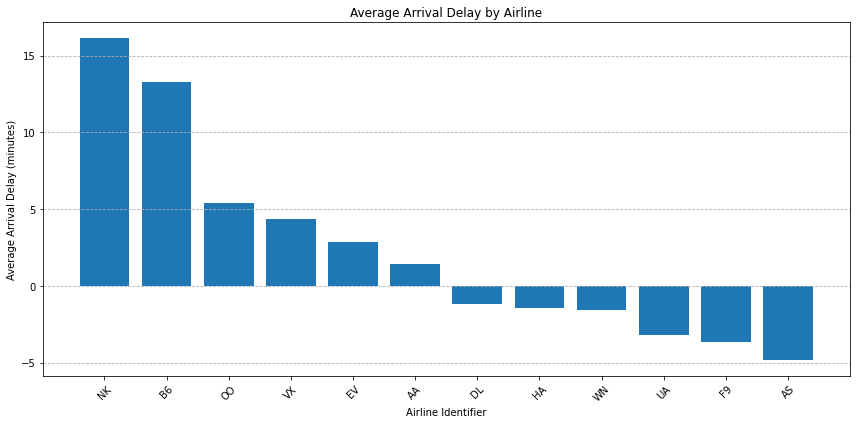

In [0]:
# Convert to Pandas DataFrame for visualization
average_delay_airline_pandas = average_delay_airline.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(average_delay_airline_pandas['AirlineIdentifier'], average_delay_airline_pandas['AverageArrivalDelay'])
plt.xlabel('Airline Identifier')
plt.ylabel('Average Arrival Delay (minutes)')
plt.title('Average Arrival Delay by Airline')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


**Visualize delay patterns over days of the week or months.**

DAY_OF_WEEK,AverageArrivalDelay
1,1.2930922260422577
2,0.9464425424974513
3,0.9241442212231522
4,1.175064476072213
5,1.3145102639296187
6,1.0439372325249643
7,1.041769521226254


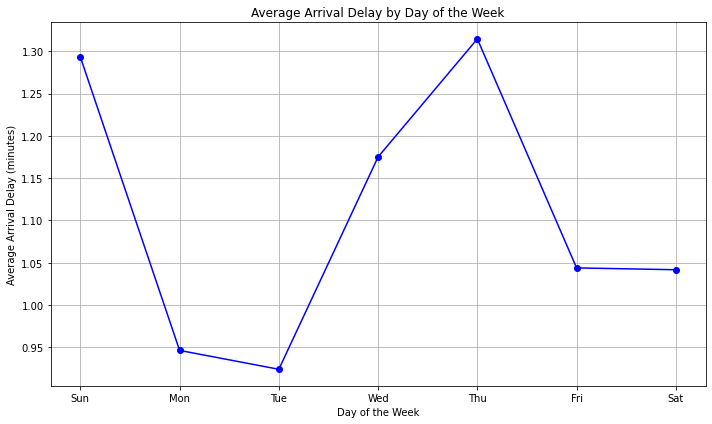

In [0]:
# Calculate average delay by day of the week
average_delay_by_day = spark.sql("""
    SELECT DAY_OF_WEEK, AVG(ArrivalDelay) AS AverageArrivalDelay
    FROM flights
    GROUP BY DAY_OF_WEEK
    ORDER BY DAY_OF_WEEK
""")

# Show the result to confirm
display(average_delay_by_day)


# Convert to Pandas DataFrame for visualization
average_delay_by_day_pandas = average_delay_by_day.toPandas()

# Plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(average_delay_by_day_pandas['DAY_OF_WEEK'], average_delay_by_day_pandas['AverageArrivalDelay'], marker='o', linestyle='-', color='b')
plt.xlabel('Day of the Week')
plt.ylabel('Average Arrival Delay (minutes)')
plt.title('Average Arrival Delay by Day of the Week')
plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7], labels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.grid(True)
plt.tight_layout()
plt.show()

**Which airlines had the highest average delays?**

From Average **ArrivalDelay by Time** plot, it appears that the airline with the highest average delay is NK, followed by B6. These two airlines have significantly higher average delays compared to others.**NK (Spirit Airlines)** has the highest average delay, with more than 15 minutes.
**B6 (JetBlue Airways)** follows with an average delay of approximately 13 minutes.
Other airlines such as OO, VX, and EV also show notable delays but are not as high as NK and B6. On the other hand, airlines like AS (Alaska Airlines), F9 (Frontier Airlines), and UA (United Airlines) show negative values, indicating these airlines are generally early or on time.

**What patterns did you observe in delays by day of the week?**

From the line plot of Average Arrival Delay by Day of the Week, the following patterns can be observed:

**Highest Delays on Sundays and Thursdays:**

Sundays have the highest average arrival delays (about 1.3 minutes), indicating that weekend congestion or returning travelers could lead to more frequent delays.
There is another peak on Thursday, which may suggest high traffic towards the end of the workweek.

**Lower Delays on Mondays and Tuesdays:**

Mondays and Tuesdays have significantly lower average delays, suggesting that these days tend to have less air traffic or fewer disruptions, possibly resulting in better on-time performance.

**Moderate Delays on Fridays and Saturdays**:

Fridays and Saturdays have consistent, moderate delays, indicating relatively stable operations on these days, without significant peaks or dips.

#### More Exploratory Data Analysis

**Calculate the percentage of cancelled flights by airline:**

+-----------------+----------------------+
|AirlineIdentifier|CancellationPercentage|
+-----------------+----------------------+
|               VX|      1.73448965977318|
|               F9|      1.64423426700618|
|               NK|      1.61207420214009|
|               WN|      1.56838542508535|
|               OO|      1.56808065640586|
|               EV|      1.56784214125232|
|               HA|      1.56636438582028|
|               B6|      1.54038487297406|
|               UA|      1.53863702614669|
|               DL|      1.53838320652885|
|               AA|      1.48075091824242|
|               AS|      1.47442399652224|
+-----------------+----------------------+



/databricks/spark/python/pyspark/sql/pandas/utils.py:124: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [CancellationPercentage] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


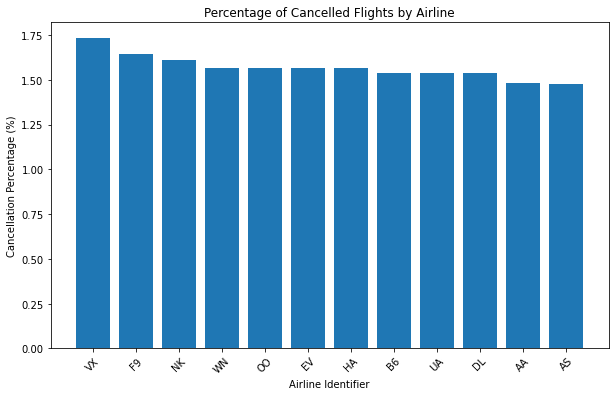

In [0]:
cancellation_percentage_airline = spark.sql("""
    SELECT AirlineIdentifier, (COUNT(*) FILTER (WHERE CANCELLED = 1) * 100.0 / COUNT(*)) AS CancellationPercentage
    FROM flights
    GROUP BY AirlineIdentifier
    ORDER BY CancellationPercentage DESC
""")
cancellation_percentage_airline.show()

cancellation_percentage_airline_pandas = cancellation_percentage_airline.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(cancellation_percentage_airline_pandas['AirlineIdentifier'], cancellation_percentage_airline_pandas['CancellationPercentage'])
plt.xlabel('Airline Identifier')
plt.ylabel('Cancellation Percentage (%)')
plt.title('Percentage of Cancelled Flights by Airline')
plt.xticks(rotation=45)
plt.show()

From the above plot , we can see that VX and F9 airlines have highest percentage of cancelled flights.

**Analyze the correlation between departure delay and arrival delay:**

In [0]:
delay_correlation = spark.sql("""
    SELECT CORR(DepDelay, ArrivalDelay) AS CorrelationBetweenDelays
    FROM flights
""")
delay_correlation.show()

+------------------------+
|CorrelationBetweenDelays|
+------------------------+
|      0.9420885390243859|
+------------------------+



##**Step 4: Conclusion**

Summary of Findings

**Average Delay by Airline:** 

The analysis showed that NK (Spirit Airlines) had the highest average delay at more than 15 minutes, followed by B6 (JetBlue Airways) with an average delay at approximately 13 minutes. On the other hand, airlines like AS (Alaska Airlines) and F9 (Frontier Airlines) had negative average delays, indicating better on-time performance.

**Top Airports with Delayed Departures:**

 The top 5 airports with the most delayed departures were identified as ATL (Hartsfield-Jackson Atlanta International Airport) with 20,495 delays, ORD (Chicago O'Hare International Airport) with 14,780 delays, LAX (Los Angeles International Airport) with 11,815 delays, DEN (Denver International Airport) with 10,868 delays, and DFW (Dallas/Fort Worth International Airport) with 9,550 delays. These airports may experience higher congestion or operational issues, indicating potential areas for targeted interventions to improve on-time performance.

**Most Common Reason for Flight Cancellations:**

 The most common reason for flight cancellations was identified as B (security Delay) with 7,344 cancellations. Understanding the main causes of cancellations can help airlines and airport authorities take proactive measures to minimize disruptions.

**Delay Patterns by Day of the Week:**

 The visualizations showed that Sundays and Thursdays experienced the highest average delays, with Sundays having an average delay of about 1.3 minutes. Mondays and Tuesdays had the lowest delays, indicating smoother operations on these days. These insights can assist airlines in better scheduling and resource allocation.